<img src='https://data.cityofchicago.org/api/assets/73F1665C-0FE6-4183-8AD1-E91DB8EFAFA4?7CB02402-8E06-48B0-8C9A-3890182D58C7.png'>

In [1]:
import pandas as pd
crime = pd.read_csv('https://raw.githubusercontent.com/evogelpohl/pandasAI_project/main/chicago_iucr.csv')

import warnings
warnings.filterwarnings('ignore')


In [2]:
df_head = crime.head(3)
df_head

,date,block,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,year,latitude,longitude,location,crime
0,2024-03-13,032XX S LAWNDALE AVE,STREET,False,False,1032,10,22,30.0,07,2024,41.834649,-87.716966,"{'latitude': '41.834649191', 'longitude': '-87...",MOTOR VEHICLE THEFT - THEFT / RECOVERY - AUTOM...
1,2024-03-13,092XX S HARVARD AVE,STREET,False,False,634,6,9,49.0,04A,2024,41.726408,-87.632162,"{'latitude': '41.726408253', 'longitude': '-87...",ASSAULT - AGGRAVATED - HANDGUN
2,2024-03-13,116XX S WALLACE ST,RESIDENCE,False,False,524,5,21,53.0,14,2024,NaN,NaN,NaN,CRIMINAL DAMAGE - TO PROPERTY


In [3]:
field_descriptions = {
    "id": "Unique identifier for the record.",
    "date": "The Date when the incident occurred. Stored as text.",
    "block": "Partially redacted address where the incident occurred, within the same block as the actual address.",
    "location_description": "Description of the location where the incident occurred.",
    "arrest": "Indicates whether an arrest was made.",
    "domestic": "Indicates whether the incident was domestic-related as per the Illinois Domestic Violence Act.",
    "beat": "Police beat where the incident occurred, part of the smallest police geographic area.",
    "district": "Police district where the incident occurred.",
    "ward": "City Council district (ward) where the incident occurred.",
    "community_area": "Indicates the community area where the incident occurred, with Chicago having 77 community areas.",
    "fbi_code": "Crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS).",
    "latitude": "Latitude of the incident location, shifted for partial redaction but on the same block.",
    "longitude": "Longitude of the incident location, shifted for partial redaction but on the same block.",
    "crime": "The crime committed, aka the incident."
}


In [4]:
import os
from pandasai import SmartDataframe
from pandasai.llm import AzureOpenAI
from pandasai.llm.local_llm import LocalLLM
from pandasai.llm import OpenAI
from pandasai import Agent
from pandasai.llm.openai import OpenAI
from pandasai.connectors import PandasConnector
from dotenv import load_dotenv
# Load environment variables from .env file
load_dotenv()

# Get my Openai Var Key
open_ai_key = os.getenv('OPENAI_API_KEY')

# Choose the model
select_model = 'OpenAI' #OpenAI $$, #AzureOpenAI #Presdio #Local MyModel mY Macbook

if select_model == 'Azure':
    # Define the LLM model for Azure (if True)
    azure_api_key = os.getenv('AZURE_OPENAI_API_KEY')
    azure_api_ver = os.getenv('AZURE_API_VERSION')
    azure_api_endpt = os.getenv('AZURE_OPENAI_ENDPOINT')
    azure_oai_deployment = os.getenv('AZURE_OPENAI_DEPLOYMENT')
    llm = AzureOpenAI(
        api_token=azure_api_key,
        azure_endpoint=azure_api_endpt,
        api_version=azure_api_ver,
        deployment_name=azure_oai_deployment,
        temperature=0,
        seed=26,
    )
elif select_model == 'OpenAI':
    openai_api_key = os.getenv('OPENAI_API_KEY')
    llm = OpenAI(api_token=openai_api_key, 
                 temperature=0,
                 seed=35,
                )
    
elif select_model == 'Local':
    llm = LocalLLM(api_base="http://host.docker.internal:1234/v1",
                  temperature=0, 
                  seed=55,
                  )


# A description of the overall table
description = '''You are a data analysis agent. Your main goal is to help non-technical users to analyze data.\
                Act as a data analyst. Every time I ask you a question, you should provide the code to visualize \
                the answer using plotly. \
                This dataset reflects reported incidents of crime (with the exception of murders where \
                data exists for each victim) that occurred in the City of Chicago from 2001 to present, \
                minus the most recent seven days. Data is extracted from the Chicago Police Department's \
                CLEAR (Citizen Law Enforcement Analysis and Reporting) system. In order to protect the privacy of crime victims, \
                addresses are shown at the block level only and specific locations are not identified. '''

# Define my connector
agent = Agent(crime, config={'llm': llm,
                            'description': description,
                            'enable_cache': False,
                            'verbose': False,
                            'field_description': field_descriptions,
                            'save_charts': True,
                            'save_charts_path': './saved_plots',
                            }
             )

'saved_plots/79db810d-0f2e-4252-8f1e-2749648c5869.png'

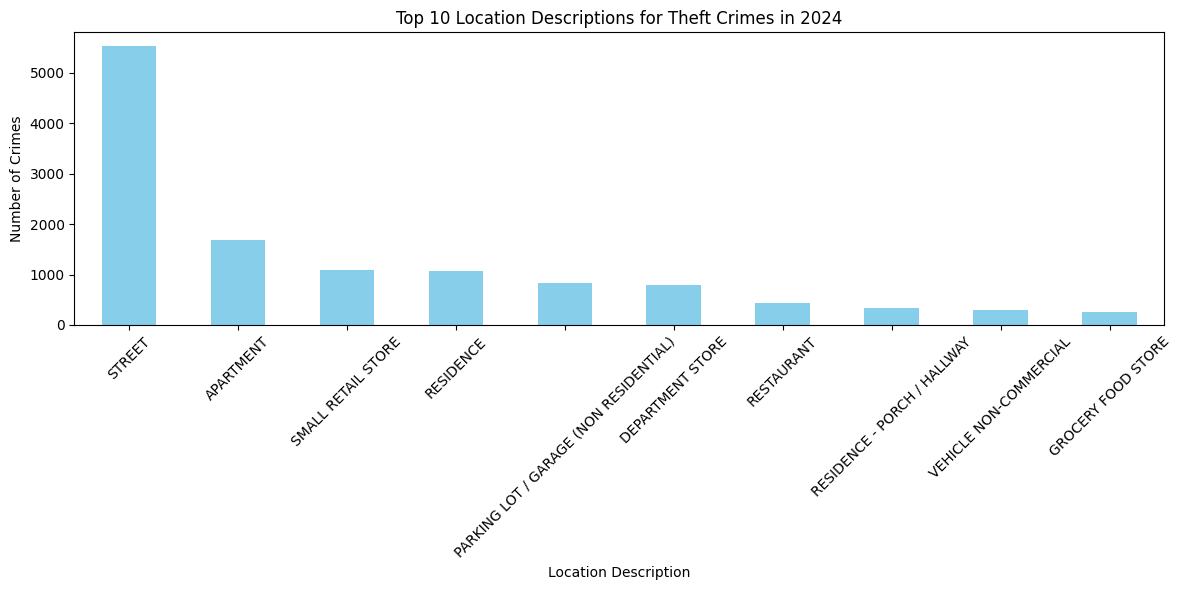

In [5]:
query = ''' Plot and show as a bar chart: Where are the top 10 location_descriptions (remove null and blank or ' ' space \
                from the chart) for the primary_type of 'THEFT' crime committed in the year 2024? Use modern color theme and \
                include in-line comments in your code please. '''
agent.chat(query)

In [6]:
print(agent.last_code_generated)

# TODO: import the required dependencies
import pandas as pd
import matplotlib.pyplot as plt

# Filter the dataframe for THEFT crimes in the year 2024
theft_2024 = dfs[0][(dfs[0]['primary_type'] == 'THEFT') & (dfs[0]['year'] == 2024)]

# Remove null and blank location_descriptions
theft_2024 = theft_2024[theft_2024['location_description'].notnull() & (theft_2024['location_description'] != ' ')]

# Get the top 10 location_descriptions
top_locations = theft_2024['location_description'].value_counts().head(10)

# Plotting the bar chart
plt.figure(figsize=(12, 6))
top_locations.plot(kind='bar', color='skyblue')
plt.title('Top 10 Location Descriptions for Theft Crimes in 2024')
plt.xlabel('Location Description')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('top_location_descriptions_theft_2024.png')

# Declare result variable
result = {"type": "plot", "value": "top_location_descriptions_theft_2024.png"}


In [7]:
agent.explain()

'I looked at the data for theft crimes in the year 2024 and filtered out any missing or empty location descriptions. Then, I found the top 10 location descriptions where these crimes occurred. I created a bar chart to visually show this information, with each bar representing a different location description. The chart is color-coded with a modern theme and includes labels for the x and y axes. Finally, I saved the chart as an image file for easy sharing.'